### Optimizing Rumor Detection: A Dual Feature Extraction Approach with LIME-Based Model Explanation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import re
import random
from collections import Counter

import warnings
warnings.filterwarnings("ignore")


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec

import nltk
from nltk.corpus import stopwords, wordnet
# from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import joblib

In [2]:
# dataset link = https://www.kaggle.com/c/fake-news/data

In [3]:
df = pd.read_csv("train.csv")

In [4]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
df.shape

(20800, 5)

In [6]:
df.label.value_counts()

1    10413
0    10387
Name: label, dtype: int64

1 ==> unreliable / rumor / fake

0 ==> reliable / non-rumor / real

Balanced Class Labels

In [7]:
df = df.drop(['id', 'author', 'title'], axis = 1)
df.head()

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20761 non-null  object
 1   label   20800 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 325.1+ KB


### Null value

In [9]:
df.isnull().sum()

text     39
label     0
dtype: int64

In [10]:
# The forwardfill() method is used to fill in missing values 
# in a DataFrame or Series with the previous valid observation

df['text'].fillna(method='ffill', inplace=True)

In [11]:
df.isnull().sum()

text     0
label    0
dtype: int64

### Duplicate value

In [12]:
df.duplicated().value_counts()

False    20409
True       391
dtype: int64

In [13]:
# dropping Duplicates

df = df.drop_duplicates(keep='first')

In [14]:
df.duplicated().value_counts()

False    20409
dtype: int64

In [15]:
df.shape

(20409, 2)

## Preprocessing

### Data Cleaning

In [16]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [17]:
print(type(stopwords))

<class 'nltk.corpus.reader.wordlist.WordListCorpusReader'>


In [18]:
# print(len(STOPWORDS))

In [19]:
# Ensure you have the necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Constants for cleaning
PUNCT_TO_REMOVE = string.punctuation + '“”'
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N": wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [20]:
# Combine all cleaning functions
def clean_text(text, FREQWORDS=None, RAREWORDS=None):
    if isinstance(text, str):
        # 1. Convert to lowercase
        text = text.lower()
        
        # 2. Remove punctuation
        text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
        
        # 3. Remove hyperlinks, markup, numbers, and special symbols
        text = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', text)
        text = re.sub('&gt;', "", text)  # Greater than sign
        text = re.sub('&#x27;', "'", text)  # Apostrophe
        text = re.sub('&quot;', '"', text)
        text = re.sub('&#x2F;', ' ', text)
        text = re.sub('<p>', ' ', text)  # Paragraph tag
        text = re.sub('<i>', ' ', text)  # Italics tag
        text = re.sub('</i>', '', text)
        text = re.sub('&#62;', '', text)
        text = re.sub("\n", '', text)  # Newline
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r"[’']", "", text)  # Remove special apostrophes

        # 4. Remove stopwords
        text = " ".join([word for word in text.split() if word not in STOPWORDS])
        
        # 5. Remove frequent words if provided
        if FREQWORDS:
            text = " ".join([word for word in text.split() if word not in FREQWORDS])
        
        # 6. Remove rare words if provided
        if RAREWORDS:
            text = " ".join([word for word in text.split() if word not in RAREWORDS])
        
        # 7. Lemmatization
        pos_tagged_text = nltk.pos_tag(text.split())
        text = " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])
        
        # 8. Remove URLs
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        text = url_pattern.sub(r'', text)
        
    return text

In [21]:
# Apply the cleaning function on the dataset
def preprocess_df(df):
    # Remove URLs, Punctuation, Lowercase, etc. in one go
    df["text"] = df["text"].apply(lambda text: clean_text(text))

    # Get frequent words and remove them
    cnt = Counter()
    for text in df["text"].values:
        for word in text.split():
            cnt[word] += 1
    FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
    
    # Get rare words and remove them
    rare_word_count = pd.Series(' '.join(df['text']).split()).value_counts()[-2:]
    RAREWORDS = list(rare_word_count.index)
    
    # Apply removal of frequent and rare words
    df["text"] = df["text"].apply(lambda text: clean_text(text, FREQWORDS=FREQWORDS, RAREWORDS=RAREWORDS))

    return df

In [22]:
# Use the function to clean and preprocess the dataframe
df = preprocess_df(df)
df.head()

,text,label
0,house dem aide didnt even see comeys letter ja...,1
1,ever get feeling life circle roundabout rather...,0
2,truth might get fired october tension intellig...,1
3,video civilian kill single u airstrike identif...,1
4,print iranian woman sentence six prison iran r...,1


In [23]:
df.shape

(20409, 2)

## Split Data

In [24]:
X = df['text']  # Features
y = df['label'] # Target

In [25]:
print(X[:1])

0    house dem aide didnt even see comeys letter ja...
Name: text, dtype: object


In [26]:
print(y)

0        1
1        0
2        1
3        1
4        1
        ..
20795    0
20796    0
20797    0
20798    1
20799    1
Name: label, Length: 20409, dtype: int64


### Feature Extraction

In [27]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Custom parameters for CountVectorizer
count_vect = CountVectorizer(max_features=10000, ngram_range=(1, 2))

# Custom parameters for TfidfVectorizer
# tfidf_vect = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [28]:
# Apply CountVectorizer
X_count = count_vect.fit_transform(X)


# Apply TfidfVectorizer
# X_tfidf = tfidf_vect.fit_transform(X)

In [29]:
# Example of correct data splitting
X_train_count, X_test_count, y_train, y_test = train_test_split(X_count, y, test_size=0.2, random_state=42)
# X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [30]:
print(f"X_train_count shape: {X_train_count.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test_count shape: {X_test_count.shape}")
print(f"y_test shape: {y_test.shape}")

# print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"X_test_tfidf shape: {X_test_tfidf.shape}")
# print(f"y_train shape: {y_test.shape}")

X_train_count shape: (16327, 10000)
y_train shape: (16327,)
X_test_count shape: (4082, 10000)
y_test shape: (4082,)


## Model Training - CountVectorizer

### 1. Logistic Regression

<IPython.core.display.Javascript object>

Cross-Validation Accuracy Scores: [0.93539498 0.9390692  0.93905054 0.93537519 0.93476263]
Mean Cross-Validation Accuracy: 0.9367
Logistic Regression with CountVectorizer:
Accuracy: 0.9434
Precision: 0.9291
Recall: 0.9551
F1 Score: 0.9419

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2120
           1       0.93      0.96      0.94      1962

    accuracy                           0.94      4082
   macro avg       0.94      0.94      0.94      4082
weighted avg       0.94      0.94      0.94      4082



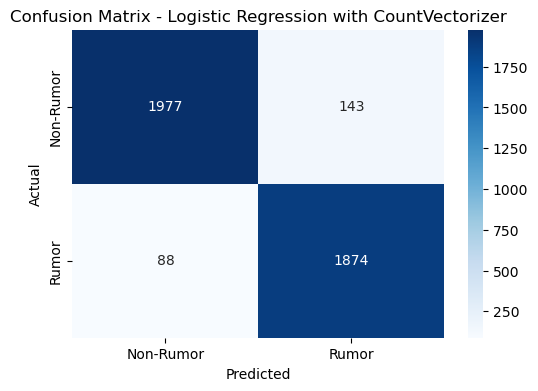

In [31]:
# Initialize the Logistic Regression model
log_reg_count = LogisticRegression(max_iter=1000, solver='lbfgs', C=1.0, penalty='l2')


# Define the k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(log_reg_count, X_train_count, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")


# Train the model on the CountVectorizer features
log_reg_count.fit(X_train_count, y_train)

# Predict on the test set
y_pred_count = log_reg_count.predict(X_test_count)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred_count)
precision = precision_score(y_test, y_pred_count)
recall = recall_score(y_test, y_pred_count)
f1 = f1_score(y_test, y_pred_count)

# Print the evaluation results
print(f"Logistic Regression with CountVectorizer:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_count))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_count)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Rumor', 'Rumor'], yticklabels=['Non-Rumor', 'Rumor'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression with CountVectorizer')
plt.show()

In [32]:
# Save the trained model to a file

joblib.dump(log_reg_count, 'logistic_regression_model_count0.pkl')

['logistic_regression_model_count0.pkl']

### 2. Naive Bayes

<IPython.core.display.Javascript object>

Cross-Validation Accuracy Scores: [0.88885487 0.8759951  0.87687596 0.88116386 0.88728943]
Mean Cross-Validation Accuracy: 0.8820
Naive Bayes with CountVectorizer:
Accuracy: 0.8782
Precision: 0.9076
Recall: 0.8313
F1 Score: 0.8678

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      2120
           1       0.91      0.83      0.87      1962

    accuracy                           0.88      4082
   macro avg       0.88      0.88      0.88      4082
weighted avg       0.88      0.88      0.88      4082



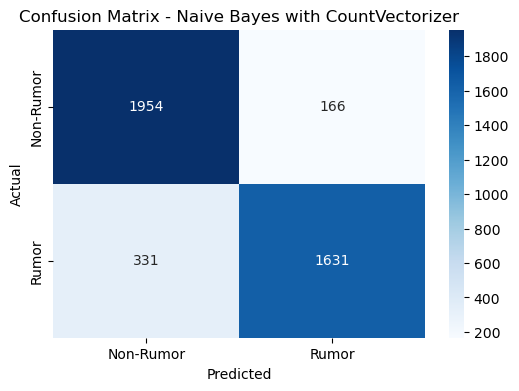

In [33]:
# Initialize the Naive Bayes model
naive_bayes_count = MultinomialNB(alpha=1.0, fit_prior=True)

# Define the k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(naive_bayes_count, X_train_count, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")

# Train the model on the CountVectorizer features
naive_bayes_count.fit(X_train_count, y_train)

# Predict on the test set
y_pred_count_nb = naive_bayes_count.predict(X_test_count)

# Evaluation Metrics
accuracy_nb = accuracy_score(y_test, y_pred_count_nb)
precision_nb = precision_score(y_test, y_pred_count_nb)
recall_nb = recall_score(y_test, y_pred_count_nb)
f1_nb = f1_score(y_test, y_pred_count_nb)

# Print the evaluation results
print(f"Naive Bayes with CountVectorizer:")
print(f"Accuracy: {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall: {recall_nb:.4f}")
print(f"F1 Score: {f1_nb:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_count_nb))

# Plot confusion matrix
conf_matrix_nb = confusion_matrix(y_test, y_pred_count_nb)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Rumor', 'Rumor'], yticklabels=['Non-Rumor', 'Rumor'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Naive Bayes with CountVectorizer')
plt.show()

In [34]:
# Save the trained model to a file

joblib.dump(naive_bayes_count, 'naive_bayes_model_count.pkl')

['naive_bayes_model_count.pkl']

### 3. Stochastic Gradient Descent (SGD)

<IPython.core.display.Javascript object>

Cross-Validation Accuracy Scores: [0.93018983 0.93631353 0.93660031 0.92557427 0.93415008]
Mean Cross-Validation Accuracy: 0.9326
Stochastic Gradient Descent (SGD) with CountVectorizer:
Accuracy: 0.9366
Precision: 0.9247
Recall: 0.9450
F1 Score: 0.9347

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2120
           1       0.92      0.94      0.93      1962

    accuracy                           0.94      4082
   macro avg       0.94      0.94      0.94      4082
weighted avg       0.94      0.94      0.94      4082



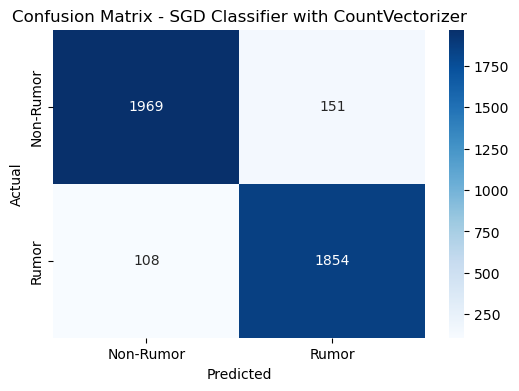

In [35]:
# Initialize the SGD Classifier model
sgd_count = SGDClassifier(loss='hinge', penalty='l2', max_iter=1000, tol=1e-3, random_state=42)

# Define the k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(sgd_count, X_train_count, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")

# Train the model on the CountVectorizer features
sgd_count.fit(X_train_count, y_train)

# Predict on the test set
y_pred_count_sgd = sgd_count.predict(X_test_count)

# Evaluation Metrics
accuracy_sgd = accuracy_score(y_test, y_pred_count_sgd)
precision_sgd = precision_score(y_test, y_pred_count_sgd)
recall_sgd = recall_score(y_test, y_pred_count_sgd)
f1_sgd = f1_score(y_test, y_pred_count_sgd)

# Print the evaluation results
print(f"Stochastic Gradient Descent (SGD) with CountVectorizer:")
print(f"Accuracy: {accuracy_sgd:.4f}")
print(f"Precision: {precision_sgd:.4f}")
print(f"Recall: {recall_sgd:.4f}")
print(f"F1 Score: {f1_sgd:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_count_sgd))

# Plot confusion matrix
conf_matrix_sgd = confusion_matrix(y_test, y_pred_count_sgd)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_sgd, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Rumor', 'Rumor'], yticklabels=['Non-Rumor', 'Rumor'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - SGD Classifier with CountVectorizer')
plt.show()


In [36]:
# Save the trained model to a file

joblib.dump(sgd_count, 'stochastic_gradient_descent_model_count.pkl')

['stochastic_gradient_descent_model_count.pkl']

### 4. K-Nearest Neighbors (KNN)

<IPython.core.display.Javascript object>

Cross-Validation Accuracy Scores: [0.69748928 0.68983466 0.68943338 0.67503828 0.69096478]
Mean Cross-Validation Accuracy: 0.6886
K-Nearest Neighbors (KNN) with CountVectorizer:
Accuracy: 0.6901
Precision: 0.6131
Recall: 0.9628
F1 Score: 0.7492

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.44      0.59      2120
           1       0.61      0.96      0.75      1962

    accuracy                           0.69      4082
   macro avg       0.77      0.70      0.67      4082
weighted avg       0.78      0.69      0.67      4082



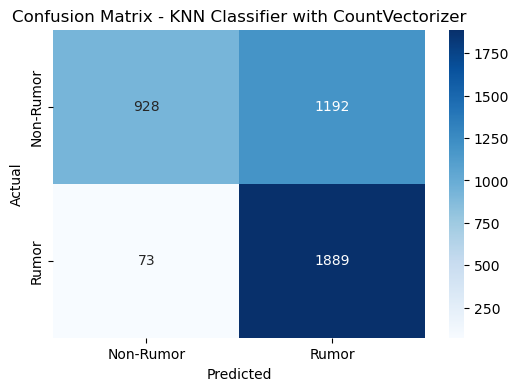

In [37]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN model
knn_count = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  # p=2 means Euclidean distance


# Define the k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(knn_count, X_train_count, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")


# Train the model on the CountVectorizer features
knn_count.fit(X_train_count, y_train)

# Predict on the test set
y_pred_count_knn = knn_count.predict(X_test_count)

# Evaluation Metrics
accuracy_knn = accuracy_score(y_test, y_pred_count_knn)
precision_knn = precision_score(y_test, y_pred_count_knn)
recall_knn = recall_score(y_test, y_pred_count_knn)
f1_knn = f1_score(y_test, y_pred_count_knn)

# Print the evaluation results
print(f"K-Nearest Neighbors (KNN) with CountVectorizer:")
print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_count_knn))

# Plot confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_count_knn)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Rumor', 'Rumor'], yticklabels=['Non-Rumor', 'Rumor'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - KNN Classifier with CountVectorizer')
plt.show()

In [38]:
# Save the trained model to a file

joblib.dump(knn_count, 'k-nearest_neighbors_model_count.pkl')

['k-nearest_neighbors_model_count.pkl']

### 5. Decision Tree

<IPython.core.display.Javascript object>

Cross-Validation Accuracy Scores: [0.82792407 0.82700551 0.83277182 0.82695253 0.82909648]
Mean Cross-Validation Accuracy: 0.8288
Decision Tree with CountVectorizer:
Accuracy: 0.8324
Precision: 0.8185
Recall: 0.8369
F1 Score: 0.8276

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2120
           1       0.82      0.84      0.83      1962

    accuracy                           0.83      4082
   macro avg       0.83      0.83      0.83      4082
weighted avg       0.83      0.83      0.83      4082



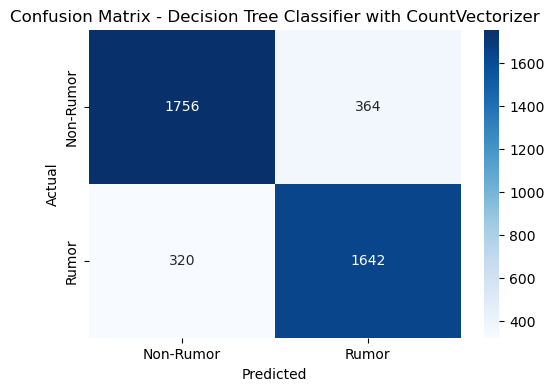

In [39]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
decision_tree_count = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, random_state=42)


# Define the k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(decision_tree_count, X_train_count, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")


# Train the model on the CountVectorizer features
decision_tree_count.fit(X_train_count, y_train)

# Predict on the test set
y_pred_count_dt = decision_tree_count.predict(X_test_count)

# Evaluation Metrics
accuracy_dt = accuracy_score(y_test, y_pred_count_dt)
precision_dt = precision_score(y_test, y_pred_count_dt)
recall_dt = recall_score(y_test, y_pred_count_dt)
f1_dt = f1_score(y_test, y_pred_count_dt)

# Print the evaluation results
print(f"Decision Tree with CountVectorizer:")
print(f"Accuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1 Score: {f1_dt:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_count_dt))

# Plot confusion matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred_count_dt)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Rumor', 'Rumor'], yticklabels=['Non-Rumor', 'Rumor'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Decision Tree Classifier with CountVectorizer')
plt.show()

In [40]:
# Save the trained model to a file

joblib.dump(decision_tree_count, 'decision_tree_model_count.pkl')

['decision_tree_model_count.pkl']

### 6. Random Forest

<IPython.core.display.Javascript object>

Cross-Validation Accuracy Scores: [0.91733007 0.91610533 0.91822358 0.91546708 0.92036753]
Mean Cross-Validation Accuracy: 0.9175
Random Forest with CountVectorizer:
Accuracy: 0.9223
Precision: 0.9345
Recall: 0.9016
F1 Score: 0.9178

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      2120
           1       0.93      0.90      0.92      1962

    accuracy                           0.92      4082
   macro avg       0.92      0.92      0.92      4082
weighted avg       0.92      0.92      0.92      4082



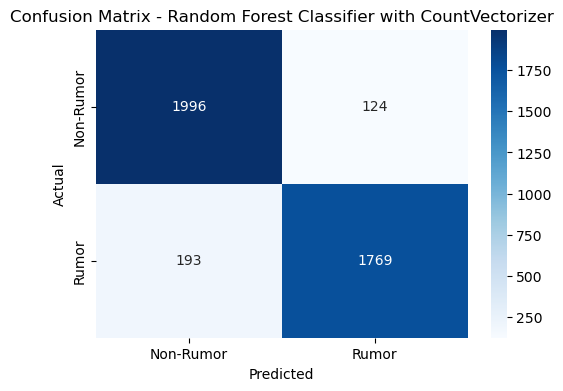

In [41]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
random_forest_count = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, random_state=42, n_jobs=-1)


# Define the k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(random_forest_count, X_train_count, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")



# Train the model on the CountVectorizer features
random_forest_count.fit(X_train_count, y_train)

# Predict on the test set
y_pred_count_rf = random_forest_count.predict(X_test_count)

# Evaluation Metrics
accuracy_rf = accuracy_score(y_test, y_pred_count_rf)
precision_rf = precision_score(y_test, y_pred_count_rf)
recall_rf = recall_score(y_test, y_pred_count_rf)
f1_rf = f1_score(y_test, y_pred_count_rf)

# Print the evaluation results
print(f"Random Forest with CountVectorizer:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_count_rf))

# Plot confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_count_rf)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Rumor', 'Rumor'], yticklabels=['Non-Rumor', 'Rumor'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Random Forest Classifier with CountVectorizer')
plt.show()

In [42]:
# Save the trained model to a file

joblib.dump(random_forest_count, 'random_forest_model_count.pkl')

['random_forest_model_count.pkl']

### 7. Support Vector Machine (SVM)

<IPython.core.display.Javascript object>

Cross-Validation Accuracy Scores: [0.91916718 0.92345377 0.92496172 0.92404288 0.92220521]
Mean Cross-Validation Accuracy: 0.9228
SVM with CountVectorizer:
Accuracy: 0.9336
Precision: 0.9221
Recall: 0.9414
F1 Score: 0.9317

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2120
           1       0.92      0.94      0.93      1962

    accuracy                           0.93      4082
   macro avg       0.93      0.93      0.93      4082
weighted avg       0.93      0.93      0.93      4082



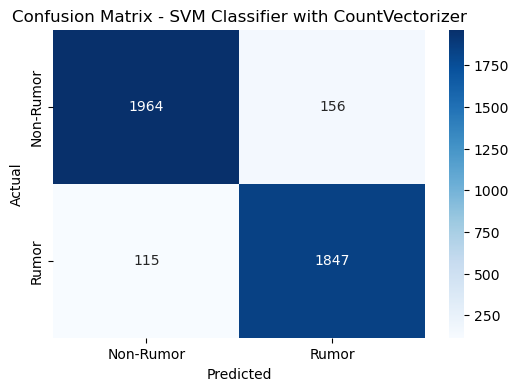

In [43]:
from sklearn.svm import SVC

# Initialize the Support Vector Machine model with a linear kernel
svm_count = SVC(kernel='linear', C=1.0, random_state=42)


# Define the k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(svm_count, X_train_count, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")


# Train the model on the CountVectorizer features
svm_count.fit(X_train_count, y_train)

# Predict on the test set
y_pred_count_svm = svm_count.predict(X_test_count)

# Evaluation Metrics
accuracy_svm = accuracy_score(y_test, y_pred_count_svm)
precision_svm = precision_score(y_test, y_pred_count_svm)
recall_svm = recall_score(y_test, y_pred_count_svm)
f1_svm = f1_score(y_test, y_pred_count_svm)

# Print the evaluation results
print(f"SVM with CountVectorizer:")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_count_svm))

# Plot confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_count_svm)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Rumor', 'Rumor'], yticklabels=['Non-Rumor', 'Rumor'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - SVM Classifier with CountVectorizer')
plt.show()


In [44]:
# Save the trained model to a file

joblib.dump(svm_count, 'svm_model_count.pkl')

['svm_model_count.pkl']